In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import csv
from scipy.signal import resample_poly

from pathlib import Path
import glob
import shutil
import os
import pickle

import sys
sys.path.append('/storage3/eva/teaching/motive/code/src')
import path_formatting as pf
import motive
import utils
import oe

## Config paths

In [11]:
student = 's01' # change accordingly
of = 'of1' # you will be given one to explore

date, animal, exp = "20250909", "eb03", '3of_hpc' # modify if needed

oe_sr = 30000 # open ephys sampling rate
m_sr = 120 # motive sampling rate

ks_path, csv_path, res_path, utils_path = utils.path_load(date, animal,exp, student, p=True)
os.makedirs(res_path, exist_ok=True) # creates ur result folder

ValueError: not enough values to unpack (expected 4, got 3)

## Load data

In [ ]:
goodspiketimes = oe.ks_load(ks_path)
with open(Path(f'{utils_path}/preprocessing') / f"behav_periods_{animal}_{date}.pkl", "rb") as f:
    periods = pickle.load(f)

Sup! U have...
67 phy-good clusters


In [8]:
periods

{'sl1': [np.int64(1), np.int64(55636839)],
 'of1': [np.int64(55637339), np.int64(109752468)],
 'sl2': [np.int64(110203161), np.int64(164604073)],
 'of2': [np.int64(164993301), np.int64(219019456)],
 'sl3': [np.int64(219329946), np.int64(273560106)],
 'of3': [np.int64(274088922), np.int64(323868824)],
 'sl4': [np.int64(324132004), np.int64(385931983)]}

In [12]:
csv_dict = motive.get_csv_dict(csv_path)

In [16]:
with open(Path(f'{utils_path}/preprocessing') / f"meta_{date}.pkl", "rb") as f:
    meta = pickle.load(f)
meta

{'of1': '20250909_1', 'of2': '20250909_2', 'of3': '20250909_3'}

## Explore tracking info

### x,y,z 

In [10]:
# helper function
def motive_quality(df, trial, save=False):

    # === Parse Meta Info ===
    motive_meta = df.iloc[0, 0:20].tolist()
    motive_meta = {motive_meta[i]: motive_meta[i + 1] for i in range(0, len(motive_meta) - 1, 2)}
    trial_duration = float(df.iloc[-1, 1])
    motive_meta['Duration'] = trial_duration

    # === Frame times & dt ===
    try:
        i = 6
        frame_times = df.iloc[i:, 1]
        frame_times = pd.to_numeric(frame_times, errors='coerce').dropna()
        dt = frame_times.diff().dropna()
    except:
        i = 7
        frame_times = df.iloc[i:, 1]
        frame_times = pd.to_numeric(frame_times, errors='coerce').dropna()
        dt = frame_times.diff().dropna()

    dt_us = dt * 1e6
    dt_min, dt_max = np.min(dt), np.max(dt)
    dt_diff_us = (dt_max - dt_min) * 1e6

    # === Position arrays & frame loss ===
    arrays, arrays_interpol = motive.get_arrays(df, metric='Position', dim_array=['X', 'Y', 'Z'], interpolate=True)
    nan_mask = np.isnan(arrays['X']) | np.isnan(arrays['Y']) | np.isnan(arrays['Z'])
    valid_mask = ~nan_mask
    x, y, z = arrays_interpol['X'], arrays_interpol['Y'], arrays_interpol['Z']

    loss_info = ""
    for key in ['X', 'Y', 'Z']:
        loss_count = np.isnan(arrays[key]).sum()
        loss_pct = 100 * loss_count / len(arrays[key])
        loss_info += f"{key}: {loss_count} ({loss_pct:.3f}%) lost frames\n"

    text_summary = (
        f"Trial: {trial}\n"
        f"___________________\n"
        f"Duration: {trial_duration:.2f} s; {trial_duration/60:.2f} min\n"
        f"fs: {motive_meta['Capture Frame Rate']} Hz\n"
        f"Frames nb: {motive_meta['Total Frames in Take']}\n"
        f"Rotation type': {motive_meta['Rotation Type']}\n"
        f"Length units': {motive_meta['Length Units']}\n"
        f"Coordinate space': {motive_meta['Coordinate Space']}\n"
        f"Min frame duration: {dt_min:.9f} s\n"
        f"Max frame duration: {dt_max:.9f} s\n"
        f"Difference: {dt_diff_us:.9f} μs\n"
        + loss_info
    )

    # === Create 2x2 plot layout ===
    fig, axes = plt.subplots(2, 2, figsize=(8, 7))

    # 1. Text summary (row 0, col 0)
    axes[0, 0].axis('off')
    axes[0, 0].text(0, 1, text_summary, va='top', ha='left', fontsize=10, family='monospace')

    # 2. XZ Trajectory with interpolation (row 0, col 1)
    axes[0, 1].scatter(x[valid_mask], z[valid_mask], c='grey', s=1, alpha=0.5)
    axes[0, 1].scatter(x[nan_mask], z[nan_mask], c='red', s=30, marker='x', label='Interpol')
    axes[0, 1].invert_xaxis()
    axes[0, 1].set_xlabel("X [m]")
    axes[0, 1].set_ylabel("Z [m]")
    axes[0, 1].set_title("XZ Traj")
    axes[0, 1].set_aspect('equal', adjustable='datalim')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # 3. IFI histogram (row 1, col 0)
    axes[1, 0].hist(dt_us, bins=50)
    axes[1, 0].set_xlabel('dt [μs]')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('Inter-frame Interval (IFI)')

    # 4. dt over time (row 1, col 1)
    axes[1, 1].plot(dt_us[:100])
    axes[1, 1].set_xlabel('Sample index')
    axes[1, 1].set_ylabel('dt [μs]')
    axes[1, 1].set_title('dt over time (first 100)')
    axes[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if save:
        filename = f'motive_quality_{trial}'
        plt.savefig(os.path.join(res_path, filename), dpi=300, bbox_inches='tight')
    plt.show()

assess tracking quality

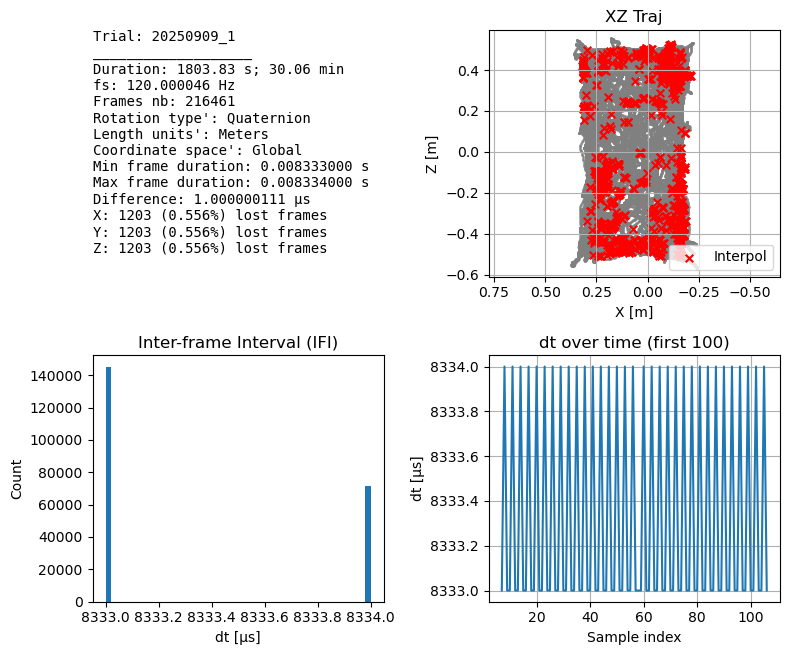

In [17]:
trial = meta[of]
df = csv_dict[trial]
motive_quality(df, trial, save=True)

plot trajectories

In [18]:
# helper function
def plot_trajectory(trial,x,z,c, c_name, c_units, save=False):
    plt.figure(figsize=(6, 4))
    sc = plt.scatter(x, z, c=c, cmap='plasma', s=1, alpha=0.5)
    plt.gca().invert_xaxis()
    plt.xlabel('X [m]')
    plt.ylabel('Z [m]')
    filename = f'xz_trjectory_{c_name}_{trial}'
    plt.colorbar(sc, label=f'{c_name} {c_units}')
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.title(filename)
    plt.tight_layout()
    if save:
        plt.savefig(os.path.join(res_path, filename), dpi=300, bbox_inches='tight')
    plt.show()

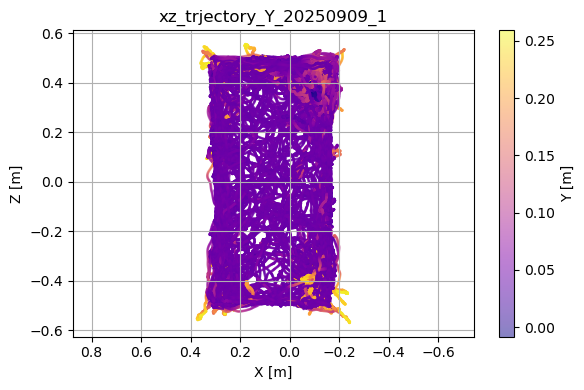

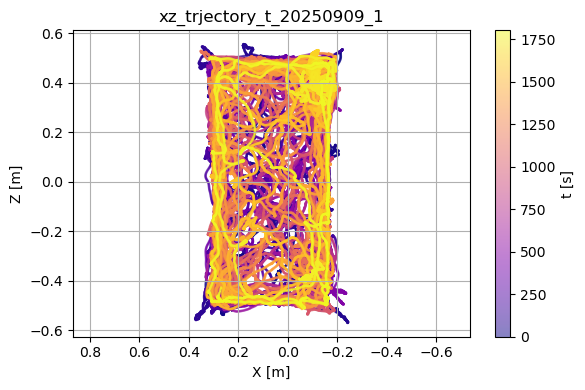

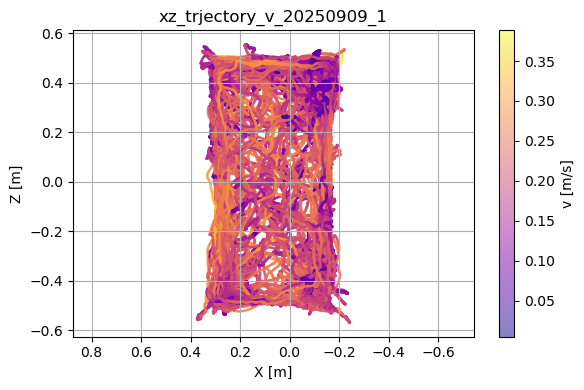

In [19]:
_, arrays_interpol = motive.get_arrays(df, metric='Position', dim_array=['X', 'Y', 'Z'], interpolate=True)
x, y, z = arrays_interpol['X'], arrays_interpol['Y'], arrays_interpol['Z']
t = motive.get_frame_times(df)
_,_,v = motive.speed(x, z, t) # smoothed

plot_trajectory(trial,x,z,y, 'Y','[m]', save=True)
plot_trajectory(trial,x,z,t, 't','[s]', save=True)
plot_trajectory(trial,x,z,v, 'v','[m/s]', save=True)

Velocity

In [20]:
# helper function

def v_plot(trial, v, t, save=False):
    fig, axes = plt.subplots(1, 2, figsize=(14, 3), gridspec_kw={'width_ratios': [1, 4]})

    # 1. Histogram of velocity
    axes[0].hist(v, bins=100)
    axes[0].set_xlabel('v [m/s]')
    axes[0].set_ylabel('Count')

    # 2. Velocity over time
    axes[1].plot(t, v)
    axes[1].set_xlabel('Time [s]')
    axes[1].set_ylabel('v [m/s]')

    filename = f"v_linear_xz_{trial}"
    fig.suptitle(filename)
    plt.tight_layout()

    if save:
        plt.savefig(os.path.join(res_path, filename), dpi=300, bbox_inches='tight')
    
    plt.show()

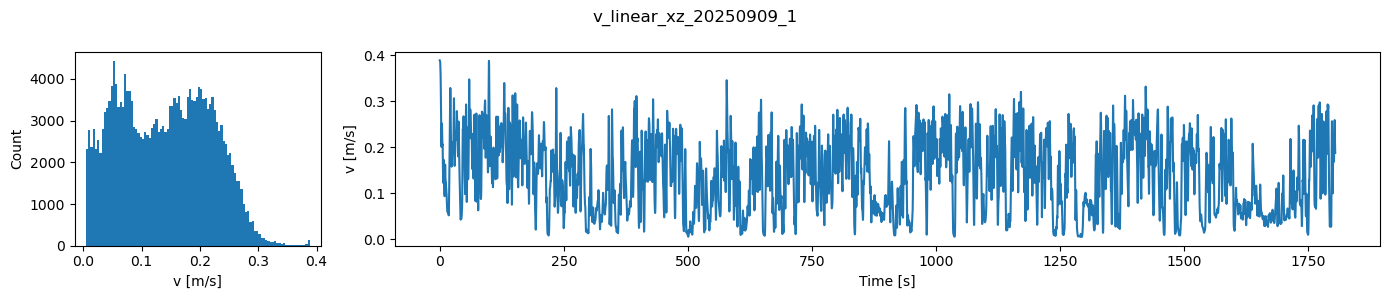

In [22]:
v_plot(trial, v, t, save=True)

### Rotations

In [23]:
from scipy.spatial.transform import Rotation as R

In [32]:
# plotting functions
 
def plot_jpdf_euler_height(of, y, roll, pitch, yaw, bins=50, save=False):
    """
    Plot joint PDFs of each Euler angle vs height, with Euler angles on x-axis.
    
    y      : array-like, height values
    roll   : array-like, roll angles (rad or deg)
    pitch  : array-like, pitch angles (rad or deg)
    yaw    : array-like, yaw angles (rad or deg)
    bins   : int or [int, int], number of bins for histogram2d
    """
    angles = [roll, pitch, yaw]
    names = ['Roll', 'Pitch', 'Yaw']

    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    for ax, ang, name in zip(axs, angles, names):
        # Now: angle is x-axis, height is y-axis
        H, xedges, yedges = np.histogram2d(ang, y, bins=bins, density=True)
        X, Y = np.meshgrid(xedges, yedges)
        pcm = ax.pcolormesh(X, Y, H.T, cmap='jet')
        ax.set_xlabel(f'{name} [deg]')
        ax.set_ylabel('Y [m]')
        fig.colorbar(pcm, ax=ax, label='Density')
    filename = f'jPDF_roll_pitch_yaw_{of}_{date}'
    fig.suptitle(filename)
    plt.tight_layout()
    if save:
        plt.savefig(os.path.join(res_path, filename), dpi=300, bbox_inches='tight')
    plt.show()

def yaw_speed(of,yaw, x,z, save=False):
    fig,axs = plt.subplots(1, 1, figsize=(4,3.5))
    d = -np.arctan2(np.diff(z), np.diff(x))
    direction = np.append(d, d[-1])
    v[v > 0.2] = 0.2 # for visualization
    
    this_plot = axs.scatter(yaw, direction, c=v, s=0.1, cmap='rainbow', alpha=0.5)
    axs.plot([-180, 180], [-np.pi, np.pi], 'k--', label='y=x')
    axs.set_xlabel('Yaw [deg]')
    axs.set_ylabel('Movement direction')
    axs.legend()
    fig.colorbar(this_plot, ax=axs, label='Speed [m/s]', fraction=0.046, pad=0.04)
    filename = f'yaw_direction_speed_{of}_{date}'
    fig.suptitle(filename)
    fig.tight_layout()
    if save:
        plt.savefig(os.path.join(res_path, filename), dpi=300, bbox_inches='tight')    
    plt.show()

def hists(of,roll, pitch, yaw, save=False):
    eu_angles = ['roll', 'pitch', 'yaw']
    fig, axs = plt.subplots(1, 3, figsize=(9,3))
    axs = axs.flatten()
    for i, eu in enumerate([roll, pitch, yaw]):
        ax = axs[i]
        ax.hist(eu, bins=100)
        ax.set_xlabel(f'{eu_angles[i]} [deg]')
        ax.set_ylabel('Count')
    filename = f'hist_roll_pitch_yaw_{of}_{date}'
    fig.suptitle(filename)
    plt.tight_layout()
    if save:
        plt.savefig(os.path.join(res_path, filename), dpi=300, bbox_inches='tight')
    plt.show()

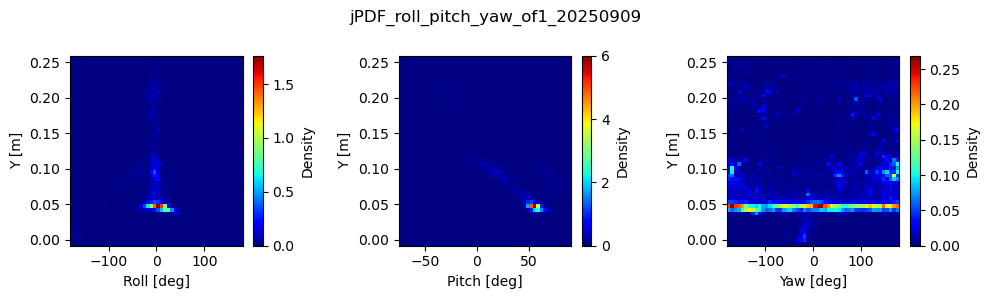

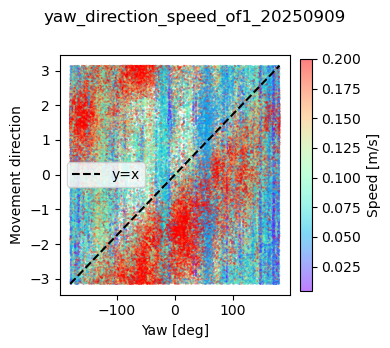

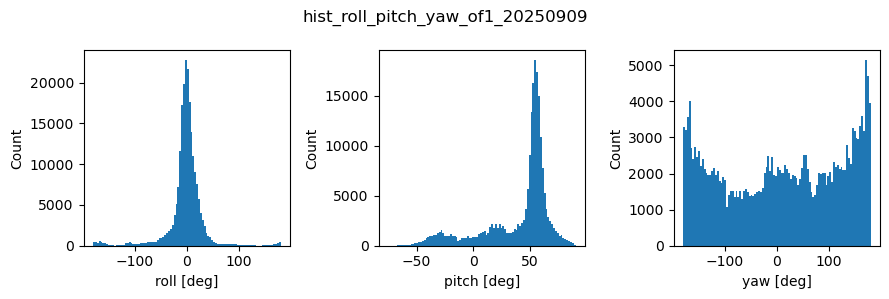

In [33]:
qt = ['X','Y','Z','W']
qt_arrays, qt_arrays_interpol = motive.get_arrays(df, metric='Rotation', dim_array = qt, interpolate=True)
quaternions = np.array([
    qt_arrays_interpol['X'], 
    qt_arrays_interpol['Y'], 
    qt_arrays_interpol['Z'],
    qt_arrays_interpol['W']
    ]).T

# one can do this
eulers = R.from_quat(quaternions).as_euler('zxy', degrees=True) # intrinsic - rotate global coordinates to rb
roll, pitch, yaw = eulers[:, 0], eulers[:, 1], eulers[:, 2]
# # or this - same result
# eulers = R.from_quat(quaternions).as_euler('YXZ', degrees=True) #extrinsis: back rotate rb to global coordinates
# yaw, pitch, roll = eulers[:, 0], eulers[:, 1], eulers[:, 2]

# plotting
save=True
plot_jpdf_euler_height(of,y,roll, pitch, yaw, save=save)
yaw_speed(of,yaw, x,z, save=save)
hists(of,roll, pitch, yaw, save=save)

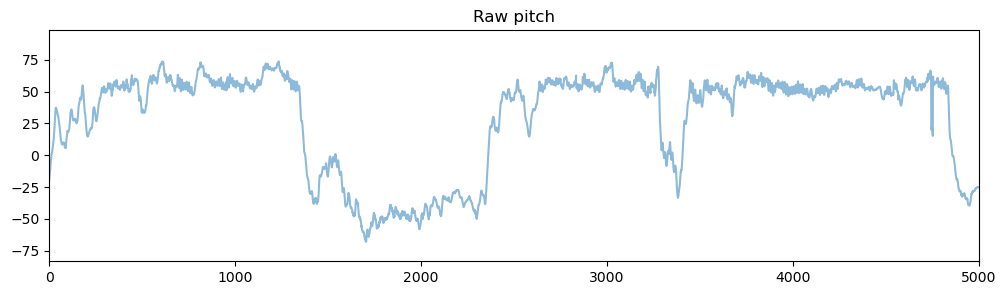

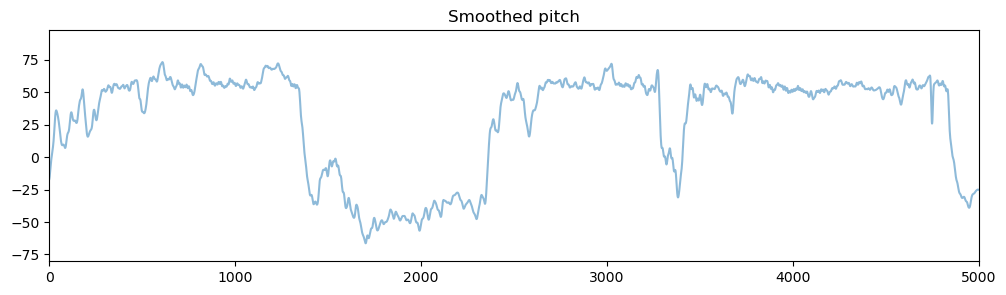

In [38]:
from scipy.ndimage import gaussian_filter1d
sigma=3
pitch_smooth = gaussian_filter1d(pitch, sigma=sigma)

# plot
a=0
b=5000

plt.figure(figsize=(12,3))
plt.plot(pitch, alpha=0.5)
plt.xlim([a,b])
plt.title('Raw pitch')
plt.show()

plt.figure(figsize=(12,3))
plt.plot(pitch_smooth, alpha=0.5)
plt.xlim([a,b])
plt.title('Smoothed pitch')
plt.show()

sniffing

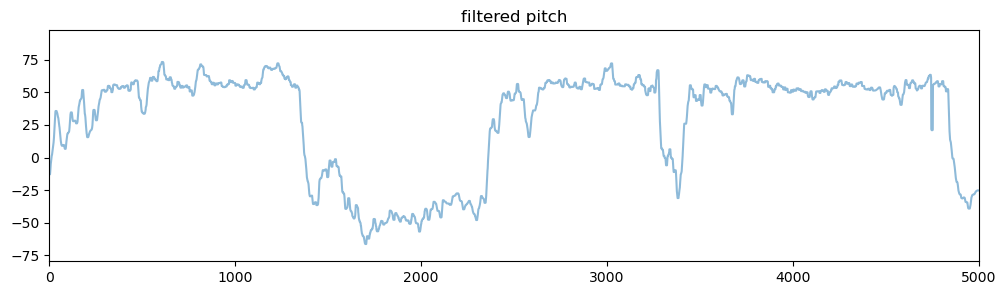

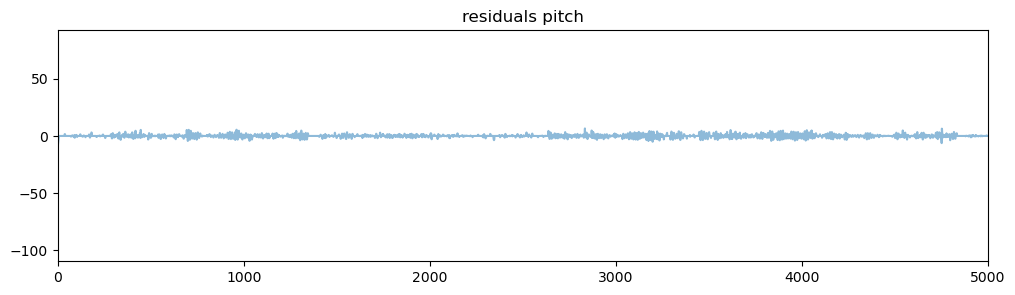

In [ ]:
from scipy.signal import medfilt

# Define kernel size (must be odd!)
kernel_size = 11  # try 11–21, depending on desired smoothness
filtered = medfilt(pitch, kernel_size=kernel_size)
residuals = pitch - filtered

# plot
a=0
b=5000

plt.figure(figsize=(12,3))
plt.plot(filtered, alpha=0.5)
plt.xlim([a,b])
plt.title('filtered pitch')
plt.show()

plt.figure(figsize=(12,3))
plt.plot(residuals, alpha=0.5)
plt.xlim([a,b])
plt.title('residuals pitch')
plt.show()

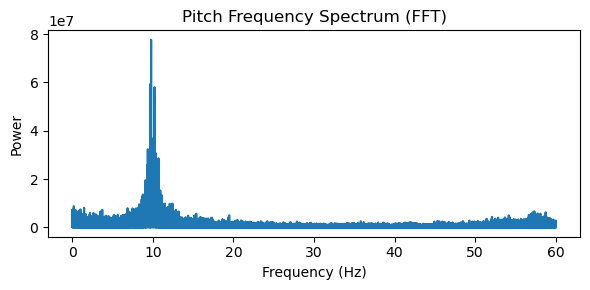

In [ ]:
fs = 120  # Motive sampling rate
n = len(residuals)
t = np.arange(n) / fs

# FFT
freqs = np.fft.rfftfreq(n, 1/fs)
fft_vals = np.fft.rfft(residuals)
power = np.abs(fft_vals)**2

# Plot
plt.figure(figsize=(6, 3))
plt.plot(freqs, power)
#plt.xlim(0, 10)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Sniffing Frequency Spectrum (FFT)")
plt.tight_layout()
plt.show()

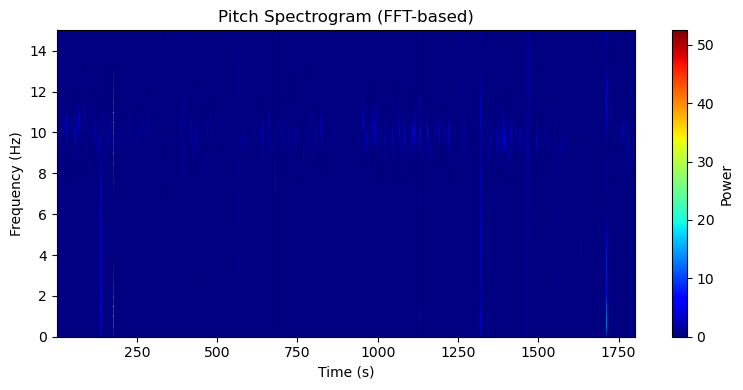

In [ ]:
from scipy.signal import spectrogram

# --- Parameters ---
fs = 120  # Motive sampling rate in Hz
win_len = 2.0  # seconds
step = 0.5     # seconds
nperseg = int(win_len * fs)
noverlap = int((win_len - step) * fs)

# --- Step 2: Spectrogram ---
f, t_spec, Sxx = spectrogram(
    residuals,
    fs=fs,
    nperseg=nperseg,
    noverlap=noverlap,
    scaling='density',  # power spectral density
    mode='psd'          # you could also try 'complex' or 'magnitude'
)

# --- Step 3: Plot spectrogram ---
plt.figure(figsize=(8, 4))
plt.pcolormesh(t_spec, f, Sxx, shading='gouraud', cmap='jet')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Sniffing Spectrogram (FFT-based)')
plt.colorbar(label='Power')
plt.ylim(0, 15)  # only low frequencies relevant for pitch
plt.tight_layout()
plt.show()

## Ephys

In [53]:
start, end = periods[of]
goodspiketimes_period = {
    unit: spikes[(spikes >= start) & (spikes <= end)] - start
    for unit, spikes in goodspiketimes.items()
}

In [54]:
goodspiketimes_period

{23: array([    9697,    13480,    13767, ..., 54093762, 54093883, 54108863],
       shape=(9686,)),
 126: array([ 8829982,  9229761,  9230157,  9230452,  9812632, 14781608,
        20220873, 21515048, 21515212, 21515300, 21515423, 26181492,
        26181939, 26182165, 26183958, 26184288, 26624655, 26624777,
        26624915, 26625014, 26772644, 26773065, 26773225, 26773343,
        26774026, 26774144, 26774361, 26774458, 26774919, 26775833,
        26776292, 26776387, 26776569, 26776753, 33745237, 33745355,
        33745524, 37164306, 37164446, 37164552, 38820995, 39098804,
        39098913, 39099160, 39099433, 39099525, 39099614, 39100251,
        39242822, 39243026, 39243123, 39243230, 39243642, 39362497,
        39362676, 39362777, 39537955, 39538091, 39538179, 39538295,
        39538408, 39538512, 39594154, 39594525, 40101414, 40621518,
        40621708, 40630106, 40635779, 40848334, 41094687, 43774776,
        43775414, 44643644, 44644092, 44646782, 44730655, 45967175,
        45

where they re on shanks

In [55]:
spiketimesfile = ks_path+"/spike_times.npy"  
spiketimes = np.load(spiketimesfile)

clusterfile = ks_path+"/spike_clusters.npy"
spikeclusters = np.load(clusterfile)

Clusterinfofile = ks_path+"/cluster_info.tsv"
Clusterinfo = pd.read_csv(Clusterinfofile,sep='\t')

In [56]:
uoi = list(goodspiketimes.keys())
print(uoi)

[23, 126, 191, 256, 287, 449, 468, 470, 471, 631, 633, 653, 658, 664, 670, 681, 683, 689, 697, 709, 711, 713, 719, 744, 754, 756, 768, 772, 784, 794, 810, 816, 820, 830, 849, 855, 867, 871, 879, 881, 886, 890, 892, 898, 900, 923, 925, 933, 935, 942, 947, 951, 953, 984, 988, 990, 993, 996, 1009, 1013, 1018, 1023, 1027, 1035, 1043, 1045, 1046]


In [57]:
Clusterinfo

,cluster_id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,group_order,n_spikes,sh
0,0,9.0,40.8,mua,489.209229,95,2595.0,0.513920,noise,3,6616,0.0
1,1,9.8,33.6,mua,492.204041,94,2610.0,1.116626,noise,3,14375,0.0
2,2,9.0,73.8,mua,499.382812,95,2595.0,0.541806,noise,3,6975,0.0
3,3,42.9,0.0,good,5353.845215,94,2610.0,1.061086,noise,3,13660,0.0
4,4,13.5,2.0,good,1889.574097,94,2610.0,0.708582,noise,3,9122,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
749,1042,18.6,65.7,mua,999.494995,217,3645.0,0.016157,noise,4,208,2.0
750,1043,18.8,25.9,mua,796.037170,80,2820.0,1.412580,good,4,18185,0.0
751,1044,18.8,25.9,mua,796.037170,80,2820.0,0.009943,noise,4,128,0.0
752,1045,21.0,4.2,good,1264.672485,176,2820.0,0.975251,good,4,12555,1.0


In [58]:
df_good_units = Clusterinfo[Clusterinfo['cluster_id'].isin(uoi)]

depth_sh_info = df_good_units[['cluster_id', 'depth', 'sh']].set_index('cluster_id').to_dict(orient='index')
print(depth_sh_info)

{23: {'depth': 2625.0, 'sh': 2.0}, 126: {'depth': 2805.0, 'sh': 1.0}, 191: {'depth': 2940.0, 'sh': 1.0}, 256: {'depth': 3045.0, 'sh': 0.0}, 287: {'depth': 3120.0, 'sh': 0.0}, 449: {'depth': 3555.0, 'sh': 2.0}, 468: {'depth': 3600.0, 'sh': 2.0}, 470: {'depth': 3600.0, 'sh': 2.0}, 471: {'depth': 3630.0, 'sh': 2.0}, 631: {'depth': 2910.0, 'sh': 1.0}, 633: {'depth': 3090.0, 'sh': 3.0}, 653: {'depth': 2850.0, 'sh': 3.0}, 658: {'depth': 3210.0, 'sh': 2.0}, 664: {'depth': 2940.0, 'sh': 1.0}, 670: {'depth': 2895.0, 'sh': 2.0}, 681: {'depth': 2595.0, 'sh': 2.0}, 683: {'depth': 2595.0, 'sh': 2.0}, 689: {'depth': 2595.0, 'sh': 2.0}, 697: {'depth': 2985.0, 'sh': 1.0}, 709: {'depth': 2910.0, 'sh': 2.0}, 711: {'depth': 2685.0, 'sh': 2.0}, 713: {'depth': 2865.0, 'sh': 1.0}, 719: {'depth': 2805.0, 'sh': 0.0}, 744: {'depth': 3690.0, 'sh': 1.0}, 754: {'depth': 2670.0, 'sh': 2.0}, 756: {'depth': 2805.0, 'sh': 1.0}, 768: {'depth': 2670.0, 'sh': 2.0}, 772: {'depth': 2700.0, 'sh': 1.0}, 784: {'depth': 2775.

In [59]:
# Convert the dict to a list of [unit_id, depth, shank]
array_data = np.array([[unit_id, vals['depth'], vals['sh']] for unit_id, vals in depth_sh_info.items()])
array_data = array_data.astype(int)

print(array_data.shape)  # (n_units, 3)
print(array_data)

(67, 3)
[[  23 2625    2]
 [ 126 2805    1]
 [ 191 2940    1]
 [ 256 3045    0]
 [ 287 3120    0]
 [ 449 3555    2]
 [ 468 3600    2]
 [ 470 3600    2]
 [ 471 3630    2]
 [ 631 2910    1]
 [ 633 3090    3]
 [ 653 2850    3]
 [ 658 3210    2]
 [ 664 2940    1]
 [ 670 2895    2]
 [ 681 2595    2]
 [ 683 2595    2]
 [ 689 2595    2]
 [ 697 2985    1]
 [ 709 2910    2]
 [ 711 2685    2]
 [ 713 2865    1]
 [ 719 2805    0]
 [ 744 3690    1]
 [ 754 2670    2]
 [ 756 2805    1]
 [ 768 2670    2]
 [ 772 2700    1]
 [ 784 2775    0]
 [ 794 2760    1]
 [ 810 2955    2]
 [ 816 3600    2]
 [ 820 3015    1]
 [ 830 2790    1]
 [ 849 2790    1]
 [ 855 2595    2]
 [ 867 2790    0]
 [ 871 2895    0]
 [ 879 3555    2]
 [ 881 2790    0]
 [ 886 3690    1]
 [ 890 2925    0]
 [ 892 2805    0]
 [ 898 2880    0]
 [ 900 2820    1]
 [ 923 2745    1]
 [ 925 2835    0]
 [ 933 2745    1]
 [ 935 2835    1]
 [ 942 2685    2]
 [ 947 2775    1]
 [ 951 2715    2]
 [ 953 2700    2]
 [ 984 3705    1]
 [ 988 3705    1]
 [

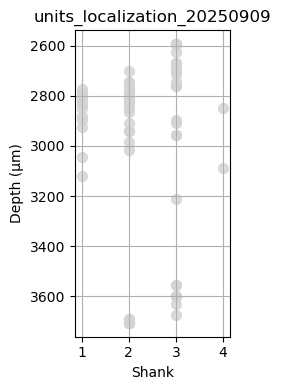

In [60]:
# Remap shank numbers: 0 → 0.5, 1 → 1.0, 2 → 1.5, 3 → 2.0
roi = []
shank_map = {0: 0.5, 1: 1.0, 2: 1.5, 3: 2.0}

unit_ids = array_data[:, 0].astype(int)
depths = array_data[:, 1]
shanks_raw = array_data[:, 2].astype(int)
shanks = np.array([shank_map[s] for s in shanks_raw])

plt.figure(figsize=(2.5, 4))

# 1. Plot all non-ROI units (dimmed and smaller)
for unit_id, depth, shank in zip(unit_ids, depths, shanks):
    if unit_id not in roi:
        plt.scatter(shank, depth, color='lightgray', s=50, alpha=0.8)

# 2. Plot ROI units (bright and larger, on top)
for unit_id, depth, shank in zip(unit_ids, depths, shanks):
    if unit_id in roi:
        color = 'red'  # Or any bright color you like
        plt.scatter(shank, depth, color=color, s=80, alpha=1.0, edgecolors='black', linewidths=0.5)

# Shank ticks and labels
plt.xticks([0.5, 1.0, 1.5, 2.0], ['1', '2', '3', '4'])
plt.gca().invert_yaxis()  # Depth increases downward
plt.xlabel('Shank')
plt.ylabel('Depth (µm)')

filename = f"units_localization_{date}"
plt.title(filename)

plt.grid(True)
plt.tight_layout()

plt.savefig(os.path.join(res_path, filename), dpi=300, bbox_inches='tight')
plt.show()

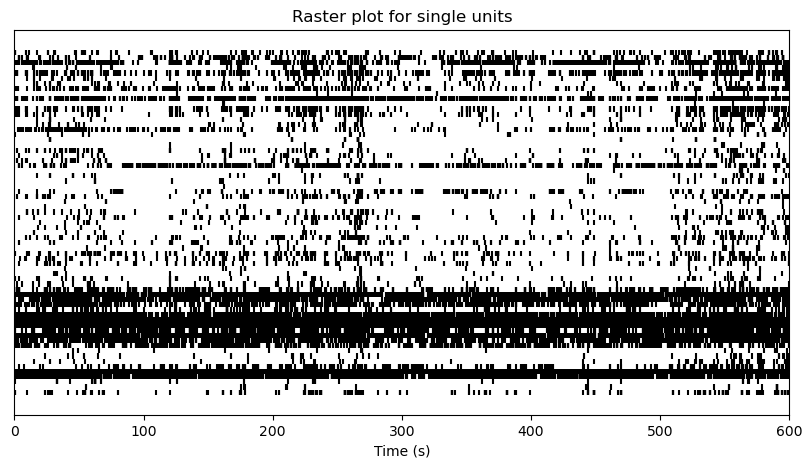

In [70]:
unit = 23
t_start, t_end = 0, 10*60  # seconds

plt.figure(figsize=(10, 5))
plt.eventplot(
    [goodspiketimes[unit][(goodspiketimes[unit]/oe_sr >= t_start) & (goodspiketimes[unit]/oe_sr < t_end)]/oe_sr for unit in uoi],
    color='k'
)
plt.xlim(t_start, t_end)
plt.xlabel('Time (s)')
plt.yticks([])
plt.title('Raster plot for single units')
plt.show()

### Place fields

In [71]:
goodspiketimes_sec = {unit: spikes / oe_sr for unit, spikes in goodspiketimes_period.items()}

In [52]:
t = motive.get_frame_times(df)
_, arrays_interpol = motive.get_arrays(df, metric='Position', dim_array = ['X','Y','Z'], interpolate=True)
x = arrays_interpol['X']
y = arrays_interpol['Y']
z = arrays_interpol['Z']

_,_,v = motive.speed(x, z, t)

t.shape, x.shape, y.shape, z.shape, v.shape

((216461,), (216461,), (216461,), (216461,), (216461,))

#### 1.  Map spike times to positional indices (i.e., 120Hz frames)

basically u re resampling ur spike times and search to what bin in motive data with 120Hz they belong to

In [ ]:
# oe data resampling - samples of 120freq with spike events
spikes_resampled = {unit: (spikes*m_sr).astype(int) for unit, spikes in goodspiketimes_sec.items()}

#### 2. Speed thresholding (>2cm/sec)

In [ ]:
speed_cutoff = 0.02 # 2cm/s
movement_mask = v > speed_cutoff 

x_moving = x[movement_mask]
z_moving = z[movement_mask]

In [74]:
x_moving.shape, z_moving.shape, x.shape, z.shape

((206296,), (206296,), (216461,), (216461,))

#### 3. Define spatial bins edges (we decided to use 5x5cm)

In [ ]:
# 5 cm bins in meters → 0.05
bin_size = 0.05

x_edges = np.arange(x.min(), x.max()  + bin_size, bin_size)
z_edges = np.arange(z.min(), z.max()  + bin_size, bin_size)

Why use x and z instead of x_moving and z_moving to define bin edges?
- Because you want to define bin edges based on the full spatial extent of the arena, not just the subset of positions where the animal was moving

#### 4. Compute occupancy map (in seconds)

- shows how much time an animal spends in different parts of space
- it’s like a heatmap of presence

In a 2D arena:
- Divide space into small bins (like 5x5cm)
- Count how long the animal was in each bin
- The result is the occupancy map

In [76]:
occupancy_counts, _, _ = np.histogram2d(x_moving, z_moving, bins=[x_edges, z_edges])
occupancy_seconds = occupancy_counts/m_sr

#smooth
from scipy.ndimage import gaussian_filter
sigma = 1.0  # adjust as needed (in bins)
occupancy_smooth = gaussian_filter(occupancy_seconds, sigma=sigma)

- smoothing kernel: sigma = 1–2 bins (e.g. 5 cm = 1 bin → smooth over 5–10 cm)
- we know that place fields are usually around 20-30 cm
--> so mb 2 bins smoothing?

In [77]:
# to plot unvisited areas as grey
# occupancy_mask = occupancy_seconds == 0

occupancy_mask = (occupancy_seconds == 0) | (occupancy_smooth < 1.0) # OR
# 0sec - exclude before smoothing
# 1sec - threshold on SMOOTHED data

In [78]:
occupancy_smooth_masked = np.where(occupancy_mask, np.nan, occupancy_smooth)

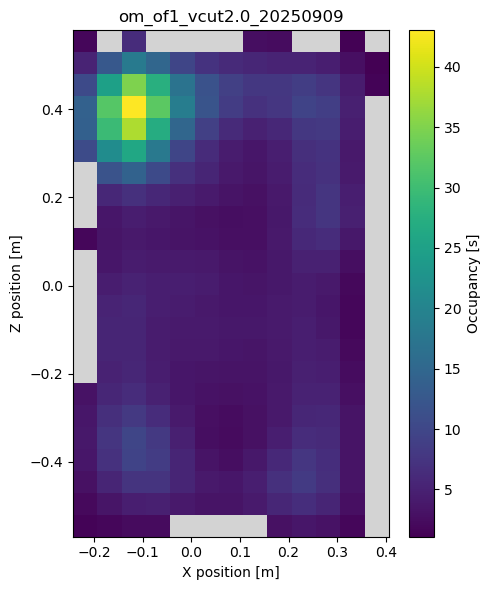

In [81]:
import matplotlib.cm as cm
save=True

# figsize=(5,4) #TOF(5,4) 
figsize=(5,6) #BOF (5,6)
plt.figure(figsize=figsize) #TOF(5,4) BOF (5,6)
cmap = cm.viridis.copy()
cmap.set_bad(color='lightgrey')  # NaNs will be shown as light grey
plt.imshow(
    occupancy_smooth_masked.T, 
    origin='lower', 
    extent=(x_edges[0], x_edges[-1], z_edges[0], z_edges[-1]),
    aspect='auto',
    cmap=cmap,
)
plt.colorbar(label='Occupancy [s]')
plt.xlabel('X position [m]')
plt.ylabel('Z position [m]')
filename = f'om_{of}_vcut{speed_cutoff*100}_{date}'
plt.title(filename)
plt.tight_layout()

if save:
    plt.savefig(Path(res_path) / f"{filename}.png", dpi=300, bbox_inches='tight')
plt.show()

In [84]:
spike_maps = {}

for cell_id, spike_idxs in spikes_resampled.items():
    # Keep only spikes during movement
    spike_idxs_moving = spike_idxs[spike_idxs < len(movement_mask)]
    spike_idxs_moving = spike_idxs_moving[movement_mask[spike_idxs_moving]]

    # Get corresponding positions of spikes
    spike_x = x[spike_idxs_moving]
    spike_z = z[spike_idxs_moving]

    spike_count_map, _, _ = np.histogram2d(spike_x, spike_z, bins=[x_edges, z_edges])
    
    # Smooth
    spike_map_smooth = gaussian_filter(spike_count_map, sigma=sigma)
    spike_map_smooth_masked = np.where(occupancy_mask, np.nan, spike_map_smooth)

    spike_maps[cell_id] = spike_map_smooth_masked

#### 5. Compute spike map for each cell

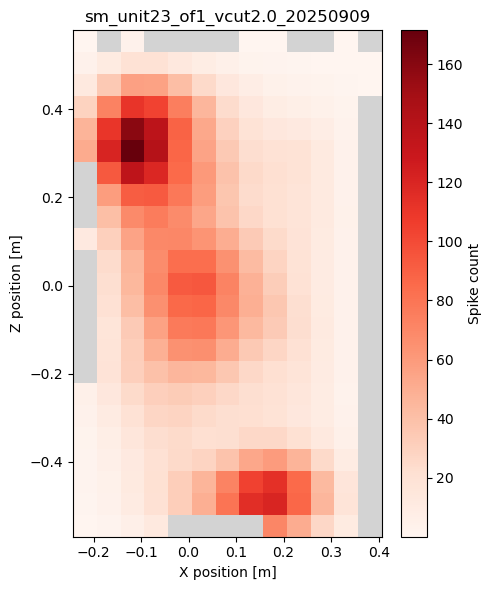

In [85]:
save=True

for unit in spike_maps.keys():

    spike_map = spike_maps[unit]

    plt.figure(figsize=figsize)

    cmap = cm.Reds.copy()
    cmap.set_bad(color='lightgrey')  # for unvisited bins
    plt.imshow(
        spike_map.T, 
        origin='lower', 
        extent=(x_edges[0], x_edges[-1], z_edges[0], z_edges[-1]),
        aspect='auto',
        cmap=cmap,
    )
    plt.colorbar(label='Spike count')
    plt.xlabel('X position [m]')
    plt.ylabel('Z position [m]')
    filename = f'sm_unit{unit}_{of}_vcut{speed_cutoff*100}_{date}'
    plt.title(filename)
    plt.tight_layout()

    if save:
        plt.savefig(Path(res_path) / f"{filename}.png", dpi=300, bbox_inches='tight')
    if unit == list(spike_maps.keys())[0]:
        plt.show()
    plt.close()

#### 6. Computre place fields (rate maps)

In [87]:
place_fields = {}
for cell_id, spike_map_smooth_masked in spike_maps.items():
    rate_map = spike_map_smooth_masked / occupancy_smooth_masked
    place_fields[cell_id] = rate_map

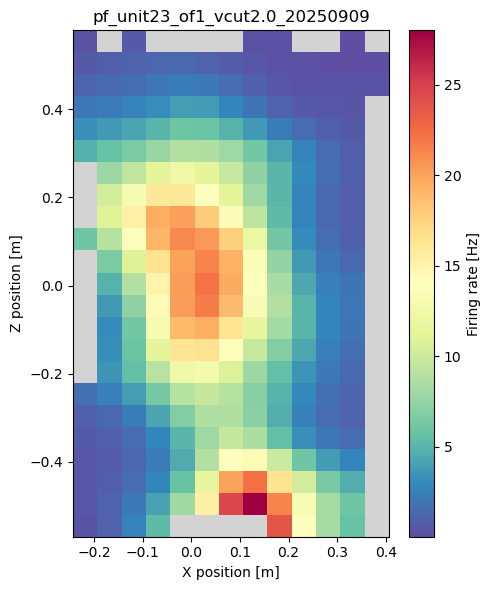

In [88]:
save=True

for unit in place_fields.keys():
    place_map = place_fields[unit]
    plt.figure(figsize=figsize)
    cmap = cm.Spectral_r.copy()
    cmap.set_bad(color='lightgrey')  # for unvisited bins
    plt.imshow(
        place_map.T, 
        origin='lower', 
        extent=(x_edges[0], x_edges[-1], z_edges[0], z_edges[-1]),
        aspect='auto',
        cmap=cmap,
    )
    plt.colorbar(label='Firing rate [Hz]')
    plt.xlabel('X position [m]')
    plt.ylabel('Z position [m]')
    filename = f'pf_unit{unit}_{of}_vcut{speed_cutoff*100}_{date}'
    plt.title(filename)
    plt.tight_layout()
    if save:
        plt.savefig(Path(res_path) / f"{filename}.png", dpi=300, bbox_inches='tight')
    if unit == list(place_fields.keys())[0]:
        plt.show()
    plt.close()